### 📌 Project Overview

This project performs an exploratory data analysis (EDA) on Google Play Store apps
to understand app characteristics, popularity patterns, pricing behavior, and
factors influencing app success.  

The analysis covers:
- Data cleaning and preprocessing
- Univariate, bivariate, and multivariate analysis
- User review sentiment analysis
- Cross-dataset insights by merging apps and reviews data


## 🔍 Initial Data Inspection

Before cleaning the dataset, we first examine its basic structure, size, missing values,
duplicates, and key columns. This helps identify potential data quality issues that need
to be addressed before analysis.


In [1]:
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Loading_dataset
df = pd.read_csv("../data/apps_data.csv")

# Dataset shape
df.shape

# Dataset structure and data types
df.info()

# Column names
df.columns

# Missing values in each column
df.isnull().sum()

# Check duplicate rows
df.duplicated().sum()

# Count apps with size listed as 'Varies with device'
(df["Size"] == "Varies with device").sum()

# Most common Size values
df["Size"].value_counts().head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Size
Varies with device    1695
11M                    198
12M                    196
14M                    194
13M                    191
15M                    184
17M                    160
19M                    154
26M                    149
16M                    149
25M                    143
20M                    139
21M                    138
10M                    136
24M                    136
18M                    133
23M                    117
22M                    114
29M                    103
27M                     97
Name: count, dtype: int64

## 🧹 Duplicate & Missing Value Handling

We begin data cleaning by checking for missing values and duplicate records.
Duplicate rows are removed to avoid biased analysis, and the index is reset
to maintain consistency.


In [2]:
# Check missing values
df.isnull().sum()

# Check duplicates
df.duplicated().sum()

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Reset index after dropping duplicates
df.reset_index(drop=True, inplace=True)


## 📝 Reviews Column Cleaning

The `Reviews` column contains values with K and M suffixes.
These are converted into numeric form for analysis.


In [3]:
# Convert Reviews to string and replace K/M notation
df["Reviews"] = (
    df["Reviews"].astype(str)
    .str.replace("M", "e6")
    .str.replace("K", "e3")
)

# Convert to numeric (invalid values become NaN)
df["Reviews"] = pd.to_numeric(df["Reviews"], errors="coerce")

# Remove rows with missing reviews
df.dropna(subset=["Reviews"], inplace=True)

# Convert to integer
df["Reviews"] = df["Reviews"].astype(int)

# Final verification
df["Reviews"].isna().sum()


np.int64(0)

## 📦 App Size Cleaning

App size values are stored as strings with units (M, k) and special values
like "Varies with device". These are converted into a numeric column in MB.


In [4]:
def convert_size(size):
    if pd.isna(size):
        return np.nan

    size = str(size)

    if size == "Varies with device":
        return np.nan

    if size.endswith("M"):
        return float(size.replace("M", ""))

    if size.endswith("k"):
        return float(size.replace("k", "")) / 1024

    return np.nan


# Create numeric size column (MB)
df["Size_MB"] = df["Size"].apply(convert_size)

# Fill missing sizes with median (NO inplace)
median_size = df["Size_MB"].median()
df["Size_MB"] = df["Size_MB"].fillna(median_size)

# Verification
df["Size_MB"].dtype
df["Size_MB"].isnull().sum()

df[["Size", "Size_MB"]].tail(10)


,Size,Size_MB
10348,9.8M,9.800000
10349,582k,0.568359
10350,619k,0.604492
10351,2.6M,2.600000
10352,9.6M,9.600000
10353,53M,53.000000
10354,3.6M,3.600000
10355,9.5M,9.500000
10356,Varies with device,13.000000
10357,19M,19.000000


## 📥 Installs Column Cleaning

The `Installs` column contains commas, plus signs, and non-numeric values.
These are cleaned and converted into integer format.


In [5]:
# Ensure string type
df["Installs"] = df["Installs"].astype(str)

# Clean text values
df["Installs"] = (
    df["Installs"]
    .str.replace(",", "", regex=False)
    .str.replace("+", "", regex=False)
    .replace("Free", np.nan)
)

# Convert to numeric
df["Installs"] = pd.to_numeric(df["Installs"], errors="coerce")

# Fill missing values with median (NO inplace)
median_installs = df["Installs"].median()
df["Installs"] = df["Installs"].fillna(median_installs)

# Convert to integer
df["Installs"] = df["Installs"].astype(int)

# Verification
df["Installs"].dtype
df["Installs"].isnull().sum()
df["Installs"].head()


0       10000
1      500000
2     5000000
3    50000000
4      100000
Name: Installs, dtype: int64

## 🏷️ App Type Cleaning

The `Type` column contains invalid zero values. These are replaced with the
most frequent category to preserve data consistency.


In [6]:
# Replace invalid zero values with NaN
df["Type"] = df["Type"].replace("0", np.nan)

# Fill missing values with mode
type_mode = df["Type"].mode()[0]
df["Type"] = df["Type"].fillna(type_mode)

# Verification
df["Type"].isnull().sum()


np.int64(0)

## 💰 App Type & Price Cleaning

This step standardizes app type values and cleans the price column by
removing symbols and converting it into numeric format.


In [7]:
# Fix invalid Type values
df["Type"].replace("0", np.nan, inplace=True)
df["Type"].fillna(df["Type"].mode()[0], inplace=True)

# Verify
df["Type"].isnull().sum()


C:\Users\Hp User\AppData\Local\Temp\ipykernel_3120\3814767219.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Type"].replace("0", np.nan, inplace=True)
C:\Users\Hp User\AppData\Local\Temp\ipykernel_3120\3814767219.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exam

np.int64(0)

In [8]:
# Convert Price to string
df["Price"] = df["Price"].astype(str)

# Handle incorrect entries
df["Price"] = df["Price"].replace("Everyone", "0")

# Remove dollar sign
df["Price"] = df["Price"].str.replace("$", "", regex=False)

# Convert to numeric
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")

# Fill missing prices (Free apps)
df["Price"] = df["Price"].fillna(0)

# Verification
df["Price"].dtype
df["Price"].isnull().sum()
df["Price"].head()



0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Price, dtype: float64

## ⭐ Rating Cleaning

Invalid ratings (greater than 5) are treated as missing values and replaced
using the median to preserve distribution.


In [9]:
# Remove invalid ratings (ratings should be between 0 and 5)
df.loc[df["Rating"] > 5, "Rating"] = np.nan

# Fill missing ratings with median
df["Rating"] = df["Rating"].fillna(df["Rating"].median())

# Verification
df["Rating"].isnull().sum()
df["Rating"].describe()



count    10358.000000
mean         4.203746
std          0.485572
min          1.000000
25%          4.100000
50%          4.300000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64

## 🔞 Content Rating Cleaning

Missing and unclassified content ratings are handled using the most frequent
category.


In [10]:
# Replace 'Unrated' with missing value
df["Content Rating"] = df["Content Rating"].replace("Unrated", np.nan)

# Fill missing content ratings with mode
df["Content Rating"] = df["Content Rating"].fillna(
    df["Content Rating"].mode()[0]
)

# Remove extra spaces
df["Content Rating"] = df["Content Rating"].str.strip()

# Verification
df["Content Rating"].value_counts()
df["Content Rating"].isnull().sum()


np.int64(0)

## 🎮 Genre Processing

Apps can belong to multiple genres. The primary genre is extracted
for simplified categorical analysis.


In [11]:
# Fix corrupted genre entry (date mistakenly placed in Genres)
df["Genres"] = df["Genres"].replace("February 11,2018", np.nan)

# Fill missing genres with the most common genre
df["Genres"] = df["Genres"].fillna(df["Genres"].mode()[0])

# Extract primary genre (before ';')
df["Primary_Genre"] = df["Genres"].str.split(";").str[0]

# Verification
df["Primary_Genre"].value_counts().head(10)
df["Primary_Genre"].isnull().sum()


np.int64(0)

## 🗓️ App Update & Version Cleaning

Dates and version information are cleaned and standardized to enable
temporal and compatibility analysis.


In [12]:
# Convert Last Updated to datetime
df["Last Updated"] = pd.to_datetime(df["Last Updated"], errors="coerce")

# Verify
df["Last Updated"].dtype
df["Last Updated"].isnull().sum()


np.int64(1)

In [13]:
# Clean Current Version information
df["Current Ver"] = df["Current Ver"].replace("Varies with device", np.nan)
df["Current Ver"] = df["Current Ver"].fillna("Unknown")

# Verification
df["Current Ver"].isnull().sum()
df["Current Ver"].value_counts().head()


Current Ver
Unknown    1310
1.0         802
1.1         260
1.2         177
2.0         149
Name: count, dtype: int64

## 🤖 Android Version Processing

Minimum supported Android versions are extracted and converted into
numeric format for analysis.


In [14]:
# Standardize Android Version column
df["Android Ver"] = df["Android Ver"].replace("Varies with device", np.nan)

# Extract minimum required Android version (e.g., '4.0.3' from '4.0.3 and up')
df["Android_Ver_Min"] = df["Android Ver"].str.extract(r"(\d+\.\d+)")

# Convert extracted version to numeric
df["Android_Ver_Min"] = pd.to_numeric(df["Android_Ver_Min"], errors="coerce")

# Fill missing values with median Android version
df["Android_Ver_Min"] = df["Android_Ver_Min"].fillna(df["Android_Ver_Min"].median())

# Verification
df["Android_Ver_Min"].dtype
df[["Android Ver", "Android_Ver_Min"]].head()



,Android Ver,Android_Ver_Min
0,4.0.3 and up,4.0
1,4.0.3 and up,4.0
2,4.0.3 and up,4.0
3,4.2 and up,4.2
4,4.4 and up,4.4


## ✅ Final Dataset Verification


In [15]:
df.columns


Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver', 'Size_MB', 'Primary_Genre', 'Android_Ver_Min'],
      dtype='object')

### 🧾 Data Cleaning Summary

- Removed duplicates and invalid entries
- Standardized numeric and categorical features
- Engineered new features (Size_MB, Primary_Genre, Android_Ver_Min)
- Prepared dataset for univariate, bivariate, and multivariate analysis


In [16]:
df.columns

df["Category"].mode()[0]
df["Type"].value_counts(normalize=True)
df["Rating"].median()
df["Size_MB"].median()
df["Installs"].median()
df["Price"].median()
df["Content Rating"].mode()[0]
df["Android_Ver_Min"].median()


np.float64(4.1)

### 📱 Profile of a Typical Google Play Store App

Based on univariate analysis:

- The typical app is **free**, as free apps dominate the platform.
- Most apps belong to popular categories such as **Family** or **Games**.
- The **median rating is around 4.2**, indicating generally positive user feedback.
- Apps are usually **lightweight**, with a median size of approximately **15 MB**.
- A typical app achieves **moderate popularity**, with installs commonly ranging between **10,000 and 100,000**.
- Most apps are rated **"Everyone"**, suggesting a broad target audience.
- The median minimum Android version requirement is **Android 4.1**, showing strong backward compatibility with older devices.

Overall, the Google Play Store is dominated by lightweight, free, family-friendly apps designed to reach a wide user base.


## ❓ Business Question  
Are most apps good, average, or bad?


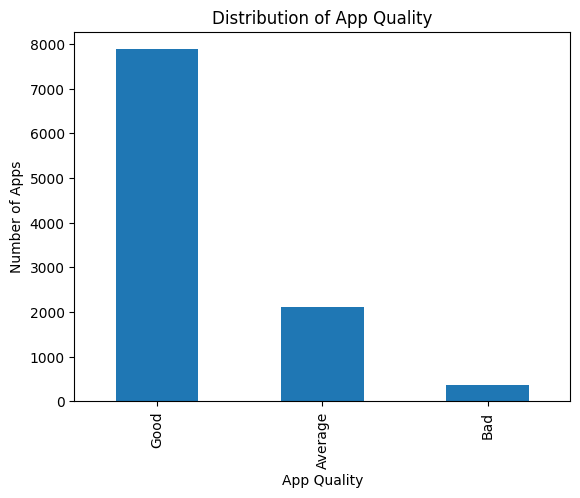

count    10358.000000
mean         4.203746
std          0.485572
min          1.000000
25%          4.100000
50%          4.300000
75%          4.500000
max          5.000000
Name: Rating, dtype: float64

In [17]:
# Create App Quality categories based on rating
bins = [0, 3, 4, 5]
labels = ["Bad", "Average", "Good"]

df["App_Quality"] = pd.cut(df["Rating"], bins=bins, labels=labels)

# Distribution
df["App_Quality"].value_counts()
df["App_Quality"].value_counts(normalize=True) * 100

# Visualization
df["App_Quality"].value_counts().plot(kind="bar")
plt.xlabel("App Quality")
plt.ylabel("Number of Apps")
plt.title("Distribution of App Quality")
plt.show()

# Rating summary
df["Rating"].describe()


### 🔍 Insight

Most apps on the Google Play Store fall into the **Good** quality category, 
with ratings between **4.0 and 5.0**. A smaller share of apps are **Average**, 
and only a few apps are rated **below 3.0**, indicating generally high overall app quality.


## ❓ Business Question  
Which types of apps dominate the Google Play Store?


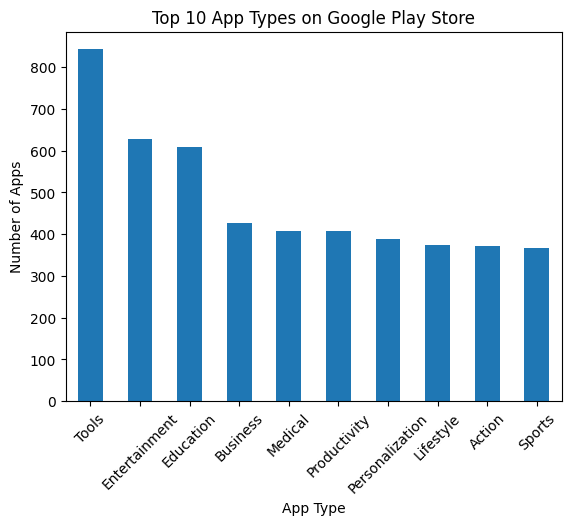

In [18]:
# Top 10 app types by count
df["Primary_Genre"].value_counts().head(10)

# Visualization
df["Primary_Genre"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 App Types on Google Play Store")
plt.xlabel("App Type")
plt.ylabel("Number of Apps")
plt.xticks(rotation=45)
plt.show()


### 🔍 Insight

Tools, Entertainment, and Education apps dominate the Google Play Store. 
Tools apps have the highest number of entries, followed by Entertainment and Education, 
indicating that utility-based and content-driven applications make up a large portion of the market.


## ❓ Business Question  
Who are apps mostly made for?


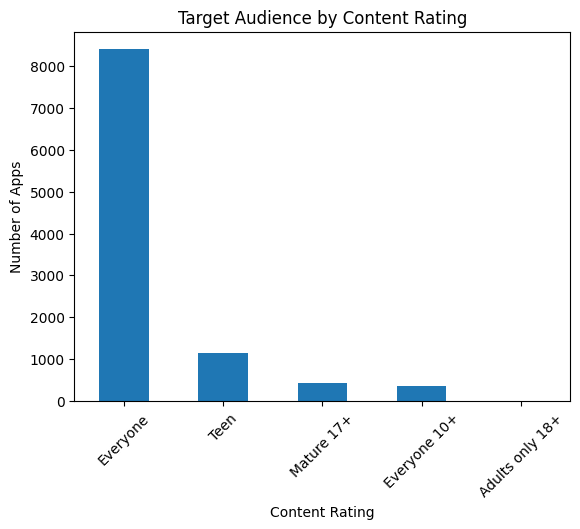

In [19]:
# Distribution of apps by content rating
df["Content Rating"].value_counts()

# Average installs by audience group
df.groupby("Content Rating")["Installs"].mean()

# Visualization
df["Content Rating"].value_counts().plot(kind="bar")
plt.title("Target Audience by Content Rating")
plt.xlabel("Content Rating")
plt.ylabel("Number of Apps")
plt.xticks(rotation=45)
plt.show()


### 🔍 Insight

Most apps on the Google Play Store are designed for **general audiences**. 
The **Everyone** content rating category has the highest number of apps, 
suggesting that developers primarily target users of all age groups rather than niche, adult-only audiences.


## ❓ Business Question  
Are most apps popular or ignored?


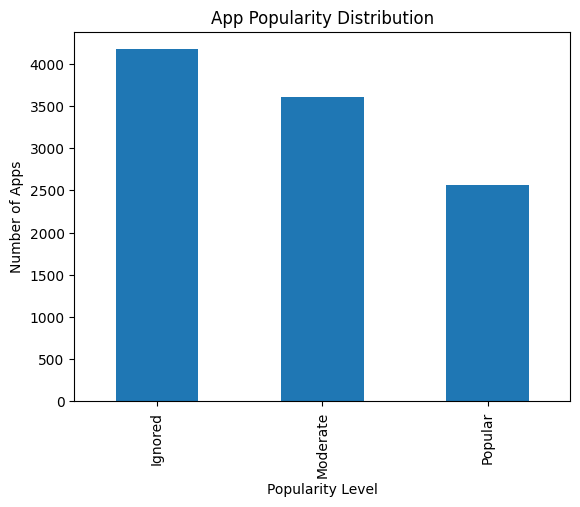

In [20]:
# Create popularity buckets based on install counts
bins = [0, 10_000, 1_000_000, df["Installs"].max()]
labels = ["Ignored", "Moderate", "Popular"]

df["Popularity_level"] = pd.cut(df["Installs"], bins=bins, labels=labels)

# Distribution of apps by popularity
df["Popularity_level"].value_counts()

# Visualization
df["Popularity_level"].value_counts().plot(kind="bar")
plt.title("App Popularity Distribution")
plt.xlabel("Popularity Level")
plt.ylabel("Number of Apps")
plt.show()


### 🔍 Insight

Most apps on the Google Play Store are relatively **ignored**.  
The majority fall into the low-install range, while only a small fraction achieve very high download counts, 
indicating a **highly skewed popularity distribution** where few apps capture most users.


## ❓ Business Question  
How hard is it to reach a large user base?


In [21]:
# Number of apps crossing major install milestones
apps_1M = (df["Installs"] >= 1_000_000).sum()

pct_1M = (df["Installs"] >= 1_000_000).mean() * 100
pct_10M = (df["Installs"] >= 10_000_000).mean() * 100
pct_100M = (df["Installs"] >= 100_000_000).mean() * 100

apps_1M, pct_1M, pct_10M, pct_100M


(np.int64(4054),
 np.float64(39.13882988994014),
 np.float64(18.17918517088241),
 np.float64(4.624444873527708))

### 🔍 Insight

Reaching a large user base on the Google Play Store is challenging.  
While around **39% of apps** cross the **1M installs** mark, only about **18%** reach **10M installs**, 
and **fewer than 5%** achieve **100M+ installs**.  

This highlights a **steep drop-off in success**, where true market dominance is rare and highly competitive.


## ❓ Business Question  
Are apps evenly distributed across categories, or do a few categories dominate the store?


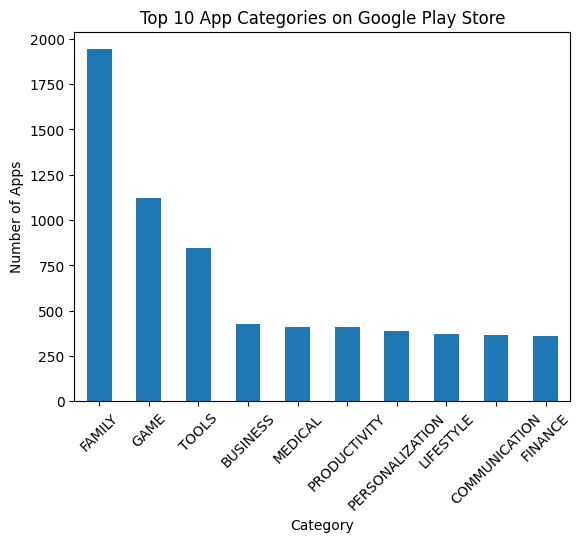

In [22]:
# Distribution of apps across categories
category_counts = df["Category"].value_counts()
category_pct = (df["Category"].value_counts(normalize=True) * 100).round(2)

category_counts, category_pct

# Visualize top 10 categories
df["Category"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 App Categories on Google Play Store")
plt.xlabel("Category")
plt.ylabel("Number of Apps")
plt.xticks(rotation=45)
plt.show()


### 🔍 Insight

Apps are **not evenly distributed** across categories.  
A small number of categories dominate the Play Store, with the **top five categories accounting for around 58%** of all apps.  
Games and Tools are the largest contributors, indicating **high competition** in these spaces, while smaller categories may offer **niche opportunities** for new developers.


## ❓ Business Question  
Are most apps truly free?  
Among paid apps, are prices clustered around low values?


In [23]:
# Distribution of free vs paid apps
df["Type"].value_counts()
(df["Type"].value_counts(normalize=True) * 100).round(2)


Type
Free    92.61
Paid     7.39
Name: proportion, dtype: float64

In [24]:
# Focus on paid apps only
paid_apps = df[df["Type"] == "Paid"]

# Summary statistics of paid app prices
paid_apps["Price"].describe()


count    765.000000
mean      13.955556
std       58.406966
min        0.990000
25%        1.490000
50%        2.990000
75%        4.990000
max      400.000000
Name: Price, dtype: float64

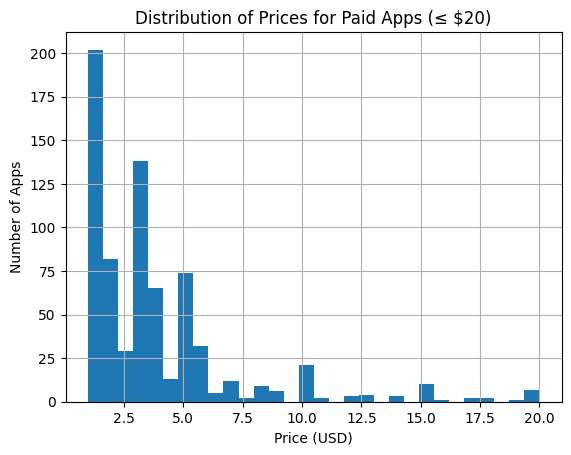

In [25]:
# Visualize price distribution (excluding extreme outliers)
paid_apps[paid_apps["Price"] <= 20]["Price"].plot(kind="hist", bins=30)

plt.title("Distribution of Prices for Paid Apps (≤ $20)")
plt.xlabel("Price (USD)")
plt.ylabel("Number of Apps")
plt.grid(True)
plt.show()


### 🔍 Insight

The Google Play Store is overwhelmingly dominated by **free apps**, with over **92%** of apps costing nothing to download.  
Among paid apps, prices are **heavily clustered at the lower end**, indicating that developers favor **low-cost or freemium monetization strategies** rather than high upfront pricing.


## ❓ Business Question  
Do most apps have very few reviews, while only a small number have very high review counts?


In [26]:
# Summary statistics of reviews
df["Reviews"].describe()


count    1.035800e+04
mean     4.061551e+05
std      2.696768e+06
min      0.000000e+00
25%      3.200000e+01
50%      1.683000e+03
75%      4.648275e+04
max      7.815831e+07
Name: Reviews, dtype: float64

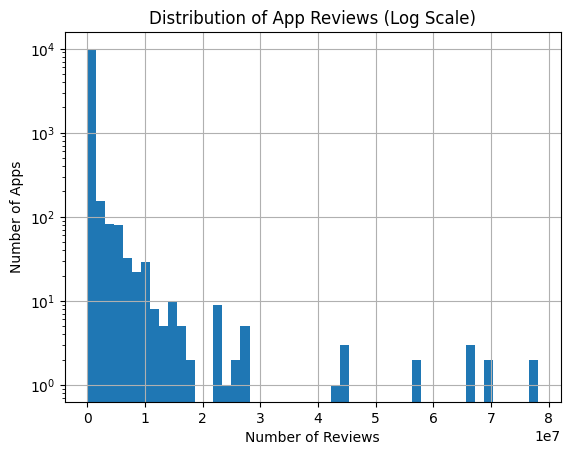

In [27]:
# Visualize review distribution (log scale for clarity)
df["Reviews"].plot(kind="hist", bins=50, log=True)

plt.title("Distribution of App Reviews (Log Scale)")
plt.xlabel("Number of Reviews")
plt.ylabel("Number of Apps")
plt.grid(True)
plt.show()


### 🔍 Insight

Most apps receive **very few reviews**, while a small fraction accumulate **


## ❓ Business Question  
Are most apps lightweight (<20MB) or heavy?


In [28]:
# Summary statistics of app size
df["Size_MB"].describe()

# Percentage of lightweight vs heavy apps
(df["Size_MB"] < 20).mean() * 100
(df["Size_MB"] >= 20).mean() * 100


np.float64(32.4676578490056)

### 🔍 Insight

Approximately **67% of apps are lightweight (<20MB)**, while about **32% are larger apps**.

### 📌 Interpretation

Most apps are designed to be lightweight, suggesting that developers prioritize **faster downloads, lower storage usage, and better accessibility**, especially for users in low-bandwidth or emerging markets.


## ❓ Business Question  
How many apps are recently maintained vs abandoned?


In [29]:
# Identify most recent update date
latest_date = df["Last Updated"].max()

# Calculate days since last update
df["Days_Since_Update"] = (latest_date - df["Last Updated"]).dt.days

# Percentage of recently maintained vs abandoned apps
recent_pct = (df["Days_Since_Update"] <= 365).mean() * 100
abandoned_pct = (df["Days_Since_Update"] > 365).mean() * 100

recent_pct, abandoned_pct




(np.float64(76.37574821394092), np.float64(23.614597412627923))

### 🔍 Insight

Approximately **76% of apps were updated within the last year**, while about **24% have not been updated for over a year**.

### 📌 Interpretation

The Play Store shows a **generally healthy maintenance culture**, with most apps receiving regular updates. However, the presence of a sizable abandoned segment suggests **uneven long-term support**, which may impact user trust and app reliability.


## ❓ Business Question  
How many apps fall into Low, Medium, and High popularity levels?


In [30]:
# Check existing popularity levels and missing values
df["Popularity_level"].unique()
df["Popularity_level"].isna().sum()

# Fill missing popularity values as "Ignored"
df["Popularity_level"] = df["Popularity_level"].fillna("Ignored")

# Distribution of popularity levels
df["Popularity_level"].value_counts()
(df["Popularity_level"].value_counts(normalize=True) * 100).round(2)


Popularity_level
Ignored     40.38
Moderate    34.84
Popular     24.77
Name: proportion, dtype: float64

### 🔍 Findings
- Approximately **40%** of apps fall into the **low popularity** category.
- Around **35%** have **moderate popularity**.
- Only about **25%** of apps achieve **high popularity**.

### 📌 Interpretation
Most apps struggle to gain significant traction on the Play Store. Only a small fraction reach high install counts, highlighting a **highly competitive and winner-takes-most market structure**.


## 📊 Bivariate Analysis  
### ❓ Do apps with more installs tend to receive more reviews?


In [31]:
# Correlation between installs and reviews
df[["Installs", "Reviews"]].corr()


,Installs,Reviews
Installs,1.000000,0.634952
Reviews,0.634952,1.000000


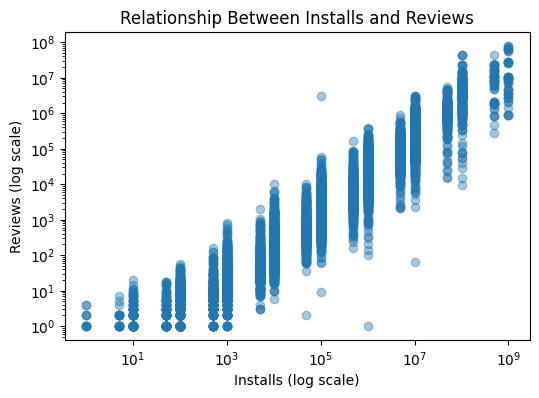

In [32]:
# Visualization (log scale to handle skewness)
plt.figure(figsize=(6, 4))
plt.scatter(df["Installs"], df["Reviews"], alpha=0.4)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Installs (log scale)")
plt.ylabel("Reviews (log scale)")
plt.title("Relationship Between Installs and Reviews")
plt.show()


### 🔍 Findings
- Installs and reviews show a **strong positive correlation**.
- The scatter plot reveals a clear upward trend: apps with more installs tend to have more reviews.

### 📌 Interpretation
Apps with higher download counts generally receive more reviews, suggesting that **user engagement scales with reach**. As an app becomes more widely adopted, a larger user base naturally leads to more feedback and reviews.


## ⭐ Bivariate Analysis  
### ❓ Do more-reviewed apps get better ratings?


In [33]:
# Correlation between number of reviews and rating
df[["Reviews", "Rating"]].corr()


,Reviews,Rating
Reviews,1.000000,0.063481
Rating,0.063481,1.000000


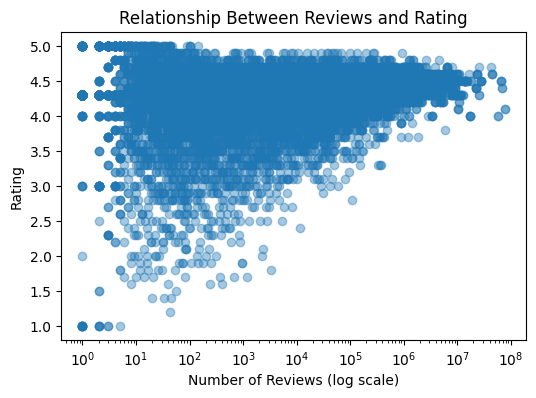

In [34]:
# Visualization (log scale for reviews)
plt.figure(figsize=(6, 4))
plt.scatter(df["Reviews"], df["Rating"], alpha=0.4)
plt.xscale("log")
plt.xlabel("Number of Reviews (log scale)")
plt.ylabel("Rating")
plt.title("Relationship Between Reviews and Rating")
plt.show()


### 🔍 Findings
- The correlation between reviews and ratings is **very weak (~0.06)**.
- The scatter plot shows no clear upward or downward trend.

### 📌 Interpretation


## 💰 Bivariate Analysis  
### ❓ Does app price affect the number of installs?


In [35]:
# Correlation between price and installs
df[["Price", "Installs"]].corr()


,Price,Installs
Price,1.000000,-0.011146
Installs,-0.011146,1.000000


### 🔍 Findings
- The correlation between **Price** and **Installs** is approximately **-0.01**, which is effectively zero


## 📊 Categorical vs Numerical Analysis

### ❓ Do free apps perform better than paid apps?


In [36]:
# Aggregate comparison
df.groupby("Type")[["Installs", "Rating", "Reviews"]].mean()
df.groupby("Type")[["Installs", "Rating", "Reviews"]].median()


,Installs,Rating,Reviews
Type,,,
Free,100000.0,4.3,2300.0
Paid,1000.0,4.3,90.0


### 📊 Free vs Paid Apps — Deeper Comparison

To further understand how app type impacts performance, we compare **ratings, installs, and reviews** for free and paid apps using boxplots.


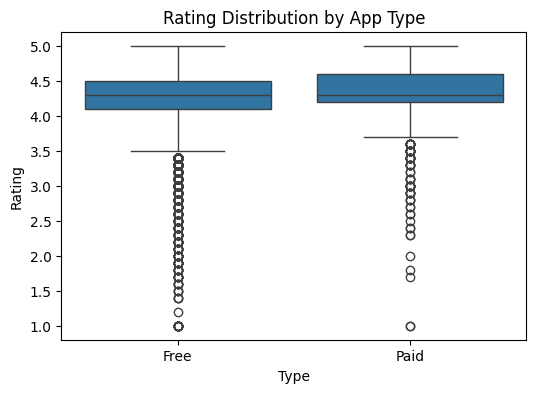

In [37]:
# Rating distribution
plt.figure(figsize=(6,4))
sns.boxplot(x="Type", y="Rating", data=df)
plt.title("Rating Distribution by App Type")
plt.show()


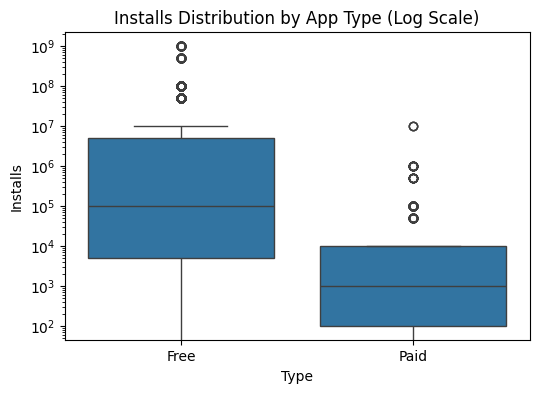

In [38]:
# Install distribution (log scale)
plt.figure(figsize=(6,4))
sns.boxplot(x="Type", y="Installs", data=df)
plt.yscale("log")
plt.title("Installs Distribution by App Type (Log Scale)")
plt.show()


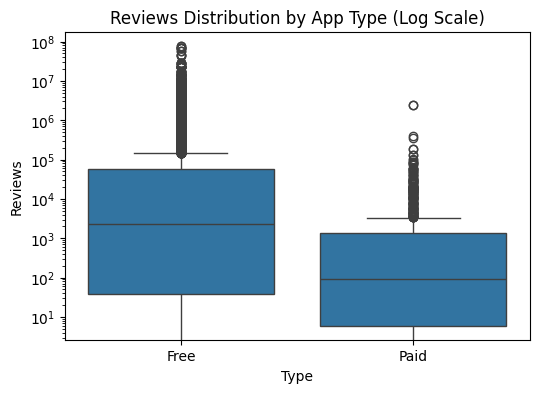

In [39]:
# Review distribution (log scale)
plt.figure(figsize=(6,4))
sns.boxplot(x="Type", y="Reviews", data=df)
plt.yscale("log")
plt.title("Reviews Distribution by App Type (Log Scale)")
plt.show()


### 🔍 Insights
- **Free apps dominate installs and reviews**, even after adjusting for extreme values using log scale.
- **Ratings are high for both free and paid apps**, with paid apps showing slightly more consistency.
- User engagement (installs & reviews) is heavily skewed toward free apps.

### 📌 Conclusion
While paid apps can maintain quality, **free apps achieve far greater reach and engagement**, making them the dominant strategy in the Play Store ecosystem.


### 📂 Category vs Installs

**Question:**  
Which app categories attract the most installs?


In [40]:
# Average installs per category
df.groupby("Category")["Installs"].mean().sort_values(ascending=False)


Category
COMMUNICATION          6.598983e+07
SOCIAL                 4.469239e+07
VIDEO_PLAYERS          3.555430e+07
PRODUCTIVITY           3.062185e+07
PHOTOGRAPHY            3.019021e+07
GAME                   2.813918e+07
TRAVEL_AND_LOCAL       2.684341e+07
ENTERTAINMENT          2.212306e+07
NEWS_AND_MAGAZINES     2.042886e+07
TOOLS                  1.358573e+07
SHOPPING               1.148816e+07
BOOKS_AND_REFERENCE    8.332476e+06
PERSONALIZATION        5.346636e+06
MAPS_AND_NAVIGATION    5.286729e+06
WEATHER                5.196348e+06
FAMILY                 5.168138e+06
HEALTH_AND_FITNESS     4.447786e+06
SPORTS                 4.354913e+06
EDUCATION              4.107323e+06
FINANCE                2.139858e+06
FOOD_AND_DRINK         2.079829e+06
BUSINESS               2.022634e+06
ART_AND_DESIGN         1.912894e+06
HOUSE_AND_HOME         1.565156e+06
LIFESTYLE              1.433843e+06
DATING                 1.053756e+06
COMICS                 9.347692e+05
LIBRARIES_AND_DEMO 

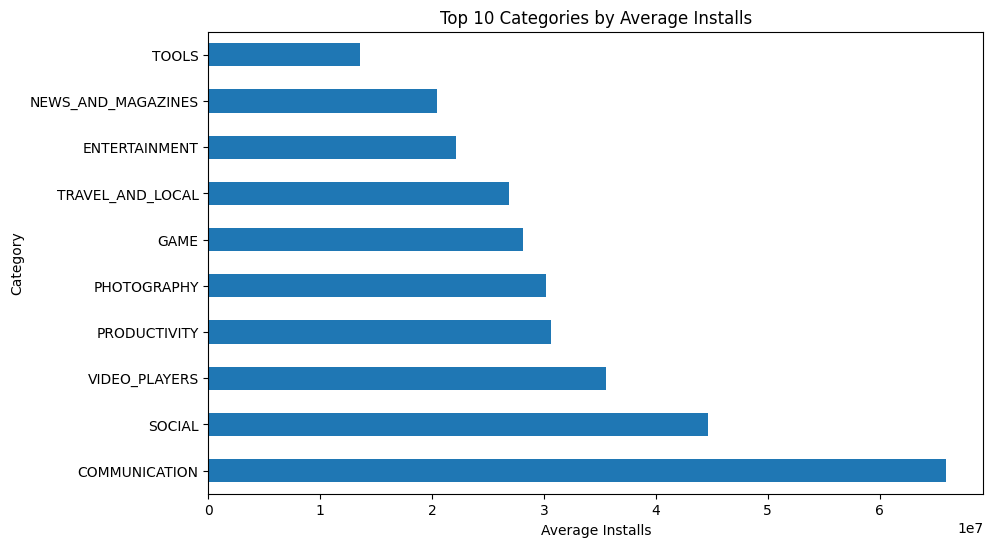

In [41]:
# Visualize top 10 categories by average installs
df.groupby("Category")["Installs"] \
  .mean() \
  .sort_values(ascending=False) \
  .head(10) \
  .plot(kind="barh", figsize=(10,6))

plt.title("Top 10 Categories by Average Installs")
plt.xlabel("Average Installs")
plt.ylabel("Category")
plt.show()


### 🔍 Findings
- **Game**, **Communication**, and **Social** categories have the highest average installs.
- These categories significantly outperform others in terms of user reach.

### 📌 Interpretation
Entertainment and communication-focused apps dominate user demand on the Play Store.  
Users are more likely to download apps that provide **social interaction, gaming, and connectivity**, making these categories highly competitive but also high-reward.


### ⭐ Category vs App Ratings

**Question:**  
Which app categories have the highest-rated apps?


In [42]:
# Average rating per category
df.groupby("Category")["Rating"].mean().sort_values(ascending=False)


Category
EVENTS                 4.395313
EDUCATION              4.375385
ART_AND_DESIGN         4.355385
BOOKS_AND_REFERENCE    4.336522
PERSONALIZATION        4.327062
1.9                    4.300000
PARENTING              4.300000
BEAUTY                 4.283019
GAME                   4.282070
HEALTH_AND_FITNESS     4.266993
SOCIAL                 4.260714
SHOPPING               4.256250
WEATHER                4.248780
SPORTS                 4.239031
PRODUCTIVITY           4.219410
MEDICAL                4.212990
LIBRARIES_AND_DEMO     4.207059
AUTO_AND_VEHICLES      4.205882
FAMILY                 4.203757
PHOTOGRAPHY            4.189441
HOUSE_AND_HOME         4.185000
FOOD_AND_DRINK         4.183871
COMMUNICATION          4.175410
BUSINESS               4.175176
NEWS_AND_MAGAZINES     4.160985
COMICS                 4.160000
FINANCE                4.148056
ENTERTAINMENT          4.136036
LIFESTYLE              4.133244
TRAVEL_AND_LOCAL       4.121941
VIDEO_PLAYERS          4.084000

### 🔍 Findings
- Average ratings across categories are consistently high, mostly ranging between **4.0 and 4.4**.
- Categories such as **Events**, **Education**, and **Art & Design** show slightly higher average ratings.

### 📌 Interpretation
User satisfaction does not vary drastically across categories, as most apps are rated positively.  
Category alone is **not a strong differentiator** of app quality.

Because ratings are bounded between **1 and 5**, mean values may mask underlying differences.  
To gain deeper insight, **median ratings and rating distributions** should also be examined.


### ⭐ Category vs App Ratings

**Question:**  
Which app categories have the highest-rated apps?


In [43]:
# Average rating per category
df.groupby("Category")["Rating"].mean().sort_values(ascending=False)


Category
EVENTS                 4.395313
EDUCATION              4.375385
ART_AND_DESIGN         4.355385
BOOKS_AND_REFERENCE    4.336522
PERSONALIZATION        4.327062
1.9                    4.300000
PARENTING              4.300000
BEAUTY                 4.283019
GAME                   4.282070
HEALTH_AND_FITNESS     4.266993
SOCIAL                 4.260714
SHOPPING               4.256250
WEATHER                4.248780
SPORTS                 4.239031
PRODUCTIVITY           4.219410
MEDICAL                4.212990
LIBRARIES_AND_DEMO     4.207059
AUTO_AND_VEHICLES      4.205882
FAMILY                 4.203757
PHOTOGRAPHY            4.189441
HOUSE_AND_HOME         4.185000
FOOD_AND_DRINK         4.183871
COMMUNICATION          4.175410
BUSINESS               4.175176
NEWS_AND_MAGAZINES     4.160985
COMICS                 4.160000
FINANCE                4.148056
ENTERTAINMENT          4.136036
LIFESTYLE              4.133244
TRAVEL_AND_LOCAL       4.121941
VIDEO_PLAYERS          4.084000

### 🔍 Findings
- Average ratings across categories are consistently high, mostly ranging between **4.0 and 4.4**.
- Categories such as **Events**, **Education**, and **Art & Design** show slightly higher average ratings.

### 📌 Interpretation
User satisfaction does not vary drastically across categories, as most apps are rated positively.  
Category alone is **not a strong differentiator** of app quality.

Because ratings are bounded between **1 and 5**, mean values may mask underlying differences.  
To gain deeper insight, **median ratings and rating distributions** should also be examined.


### 👥 Content Rating vs App Ratings

**Question:**  
Which audience age group has the highest average app ratings?


In [44]:
# Average rating by content rating
df.groupby("Content Rating")["Rating"].mean().sort_values(ascending=False)


Content Rating
Adults only 18+    4.300000
Everyone 10+       4.256233
Teen               4.245462
Everyone           4.199129
Mature 17+         4.138479
Name: Rating, dtype: float64

### 🔍 Findings
- **Adults Only (18+)** apps have the highest average rating (~4.30).
- Ratings across other age groups are very close to each other.

### 📌 Interpretation
Apps targeting mature audiences show slightly higher user satisfaction.  
However, the small differences in average ratings suggest that **content rating does not strongly influence app quality**, and users across all age groups generally report positive experiences.


### ⭐ App Quality vs Installs

**Question:**  
Do higher-quality apps receive more installs?


In [45]:
# Average installs by app quality
df.groupby("App_Quality")["Installs"].mean()


C:\Users\Hp User\AppData\Local\Temp\ipykernel_3120\350794358.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("App_Quality")["Installs"].mean()


App_Quality
Bad        1.680993e+05
Average    8.374497e+06
Good       1.635769e+07
Name: Installs, dtype: float64

### 🔍 Findings
- **Good-quality apps** have the highest average installs.
- Average-quality apps follow.
- Bad-quality apps receive the fewest installs.

### 📌 Interpretation
There is a clear positive relationship between **app quality and download volume**.  
Higher-rated apps tend to attract significantly more users, suggesting that **quality and user satisfaction play a key role in app adoption**.


### 💰 App Type vs Popularity Level

**Question:**  
How are free and paid apps distributed across popularity levels?


In [46]:
# Cross-tabulation of app type and popularity
pd.crosstab(df["Type"], df["Popularity_level"])


Popularity_level,Ignored,Moderate,Popular
Type,,,
Free,3580,3450,2563
Paid,603,159,3


### 🔍 Findings
- **Free apps dominate across all popularity levels**.
- Nearly all **highly popular apps are free**.
- **Paid apps** are mostly concentrated in the *Ignored* and *Moderate* categories.
- Paid apps are **rare among highly popular apps**.

### 📌 Interpretation
Free distribution appears to be a major driver of large-scale adoption.  
Price acts as a barrier to entry, significantly reducing the likelihood that paid apps achieve high popularity.


### 📱 Category-wise Popularity Analysis

**Question:**  
Which app categories have a higher proportion of popular apps?


In [47]:

# Remove invalid category entries (numeric noise)
df = df[~df["Category"].str.contains(r"^\d", na=False)]

# Cross-tabulation
pd.crosstab(df["Category"], df["Popularity_level"])


Popularity_level,Ignored,Moderate,Popular
Category,,,
ART_AND_DESIGN,21,35,9
AUTO_AND_VEHICLES,34,46,5
BEAUTY,24,27,2
BOOKS_AND_REFERENCE,121,69,40
BUSINESS,302,85,40
COMICS,19,35,6
COMMUNICATION,137,83,146
DATING,92,84,20
EDUCATION,7,85,38


In [48]:
# Row-wise normalized proportions
pd.crosstab(
    df["Category"],
    df["Popularity_level"],
    normalize="index"
)


Popularity_level,Ignored,Moderate,Popular
Category,,,
ART_AND_DESIGN,0.323077,0.538462,0.138462
AUTO_AND_VEHICLES,0.400000,0.541176,0.058824
BEAUTY,0.452830,0.509434,0.037736
BOOKS_AND_REFERENCE,0.526087,0.300000,0.173913
BUSINESS,0.707260,0.199063,0.093677
COMICS,0.316667,0.583333,0.100000
COMMUNICATION,0.374317,0.226776,0.398907
DATING,0.469388,0.428571,0.102041
EDUCATION,0.053846,0.653846,0.292308


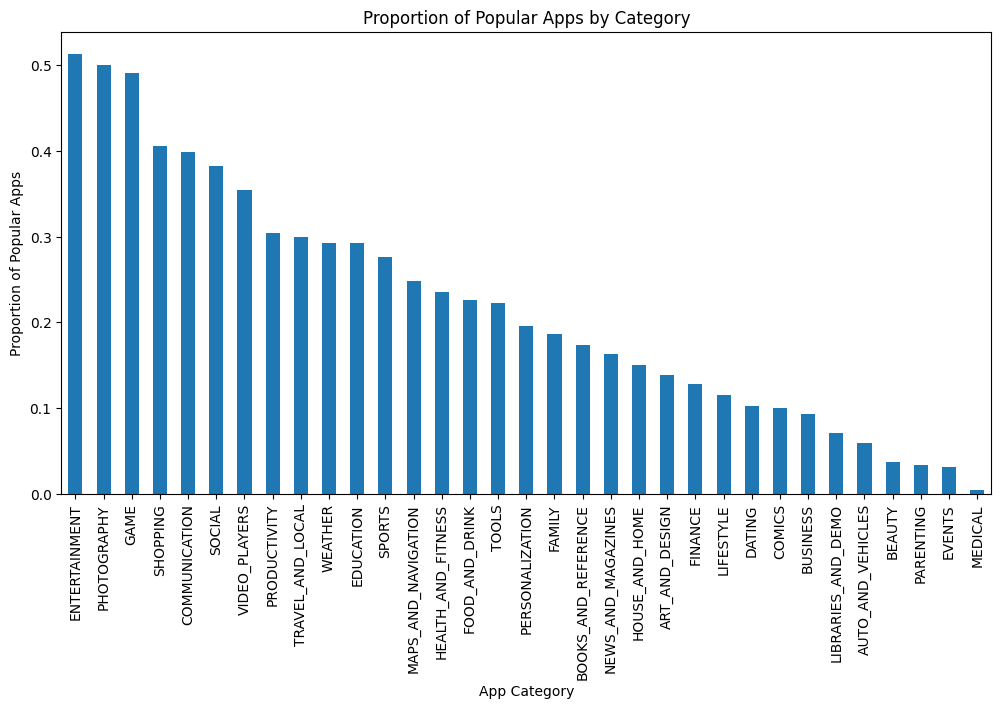

In [49]:
# Visualize proportion of popular apps by category
pd.crosstab(
    df["Category"],
    df["Popularity_level"],
    normalize="index"
)["Popular"] \
.sort_values(ascending=False) \
.plot(
    kind="bar",
    figsize=(12,6),
    title="Proportion of Popular Apps by Category"
)

plt.ylabel("Proportion of Popular Apps")
plt.xlabel("App Category")
plt.show()


### 🔍 Findings
- Categories such as **Game, Communication, and Social** show a higher proportion of popular apps.
- Utility-heavy or niche categories tend to have a lower share of popular apps.
- Popularity is not evenly distributed across categories.

### 📌 Interpretation
User demand is strongly concentrated in **entertainment and communication-focused categories**.  
Apps in these categories have a higher chance of reaching large audiences, while other categories face tougher visibility and adoption challenges.


### ⭐ App Quality vs Popularity

**Question:**  
Does app quality influence popularity level?


In [50]:
# Cross-tabulation: App Quality vs Popularity Level
pd.crosstab(df["App_Quality"], df["Popularity_level"])


Popularity_level,Ignored,Moderate,Popular
App_Quality,,,
Bad,263,92,7
Average,752,1020,350
Good,3168,2496,2209


In [51]:
# Row-wise normalized proportions
pd.crosstab(
    df["App_Quality"],
    df["Popularity_level"],
    normalize="index"
)


Popularity_level,Ignored,Moderate,Popular
App_Quality,,,
Bad,0.726519,0.254144,0.019337
Average,0.354383,0.480679,0.164939
Good,0.402388,0.317033,0.280579


### 🔍 Findings
- Only **~2%** of **Bad-quality** apps reach high popularity.
- Around **~16%** of **Average-quality** apps become popular.
- Nearly **~28%** of **Good-quality** apps achieve high popularity.

### 📌 Interpretation
App quality has a **strong positive influence** on popularity.  
Higher-quality apps are significantly more likely to reach large user bases, while low-quality apps rarely become popular. This highlights the importance of product quality as a key driver of market success.


❓ Do free apps become popular even if their quality is only average?

In [52]:
pd.crosstab(
    [df["Type"], df["App_Quality"]],
    df["Popularity_level"],
    normalize=True
)


Popularity_level   Ignored  Moderate   Popular
Type App_Quality                              
Free Bad          0.022497  0.008883  0.000676
     Average      0.063339  0.097229  0.033794
     Good         0.259824  0.226900  0.212996
Paid Bad          0.002897  0.000000  0.000000
     Average      0.009269  0.001255  0.000000
     Good         0.046056  0.014097  0.000290

Free apps are more likely to become popular even when their quality is only average.
This indicates that pricing strategy can partially offset moderate app quality, helping free apps reach wider adoption.

❓ Which categories benefit most from being free?

In [53]:
# Popularity distribution by Category and Type
ct = pd.crosstab(
    [df["Category"], df["Type"]],
    df["Popularity_level"],
    normalize="index"
)

# Extract popularity rate
popular_rates = ct["Popular"]

# Compare Free vs Paid apps
popular_df = popular_rates.unstack()

# Measure free pricing advantage
popular_df["Free_Benefit"] = popular_df["Free"] - popular_df["Paid"]

popular_df.sort_values("Free_Benefit", ascending=False)


Type,Free,Paid,Free_Benefit
Category,,,
PHOTOGRAPHY,0.533113,0.000000,0.533113
ENTERTAINMENT,0.522936,0.000000,0.522936
GAME,0.528902,0.012048,0.516854
COMMUNICATION,0.430678,0.000000,0.430678
SHOPPING,0.409910,0.000000,0.409910
SOCIAL,0.386282,0.000000,0.386282
VIDEO_PLAYERS,0.362573,0.000000,0.362573
PRODUCTIVITY,0.327177,0.000000,0.327177
WEATHER,0.324324,0.000000,0.324324


Free apps show a clear popularity advantage—especially in mass-market categories—demonstrating that pricing strategy can significantly boost adoption even when app quality is only average.


### 💰 Ratings of Popular Paid vs Free Apps

**Question:**  
Are popular paid apps rated higher than popular free apps?


In [54]:
df.pivot_table(
    values="Rating",
    index="Popularity_level",
    columns="Type",
    aggfunc="mean"
)



C:\Users\Hp User\AppData\Local\Temp\ipykernel_3120\1029473756.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(


Type,Free,Paid
Popularity_level,,
Ignored,4.167877,4.228358
Moderate,4.146941,4.418868
Popular,4.310730,4.533333


C:\Users\Hp User\AppData\Local\Temp\ipykernel_3120\220457782.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df.pivot_table(


<Axes: title={'center': 'Average Rating by Popularity Level and App Type'}, xlabel='Popularity_level', ylabel='Average Rating'>

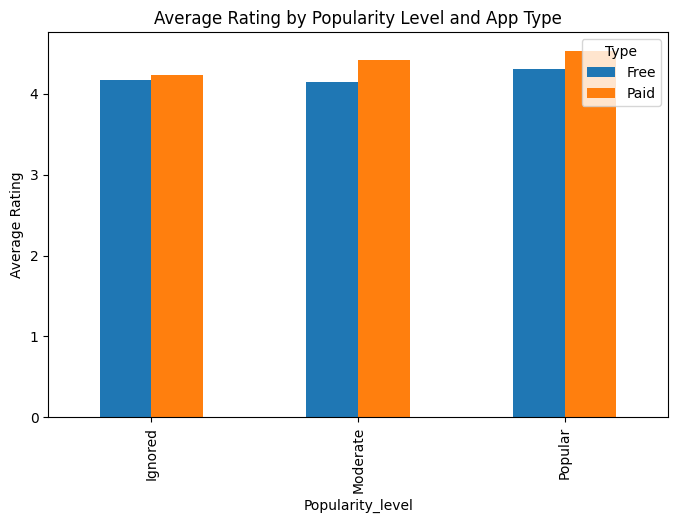

In [55]:
df.pivot_table(
    values="Rating",
    index="Popularity_level",
    columns="Type",
    aggfunc="mean"
).plot(
    kind="bar",
    figsize=(8,5),
    title="Average Rating by Popularity Level and App Type",
    ylabel="Average Rating"
)



### 🔍 Findings
- Among **popular apps**, paid apps show a **slightly higher average rating** than free apps.
- The rating difference is **small**, indicating that popularity does not strongly depend on being paid or free once an app succeeds.

### 📌 Interpretation
While paid


In [56]:
# 📊 Average Rating by Category and Popularity Level

# Create pivot table
pivot = df.pivot_table(
    values="Rating",
    index="Category",
    columns="Popularity_level",
    aggfunc="mean"
)


# Display pivot table
pivot


C:\Users\Hp User\AppData\Local\Temp\ipykernel_3120\1681757472.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


Popularity_level,Ignored,Moderate,Popular
Category,,,
ART_AND_DESIGN,4.433333,4.288571,4.433333
AUTO_AND_VEHICLES,4.055882,4.297826,4.380000
BEAUTY,4.258333,4.307407,4.250000
BOOKS_AND_REFERENCE,4.282645,4.389855,4.407500
BUSINESS,4.175166,4.144706,4.240000
COMICS,4.173684,4.145714,4.200000
COMMUNICATION,4.120438,4.077108,4.282877
DATING,4.160870,3.872619,4.125000
EDUCATION,4.314286,4.347059,4.450000


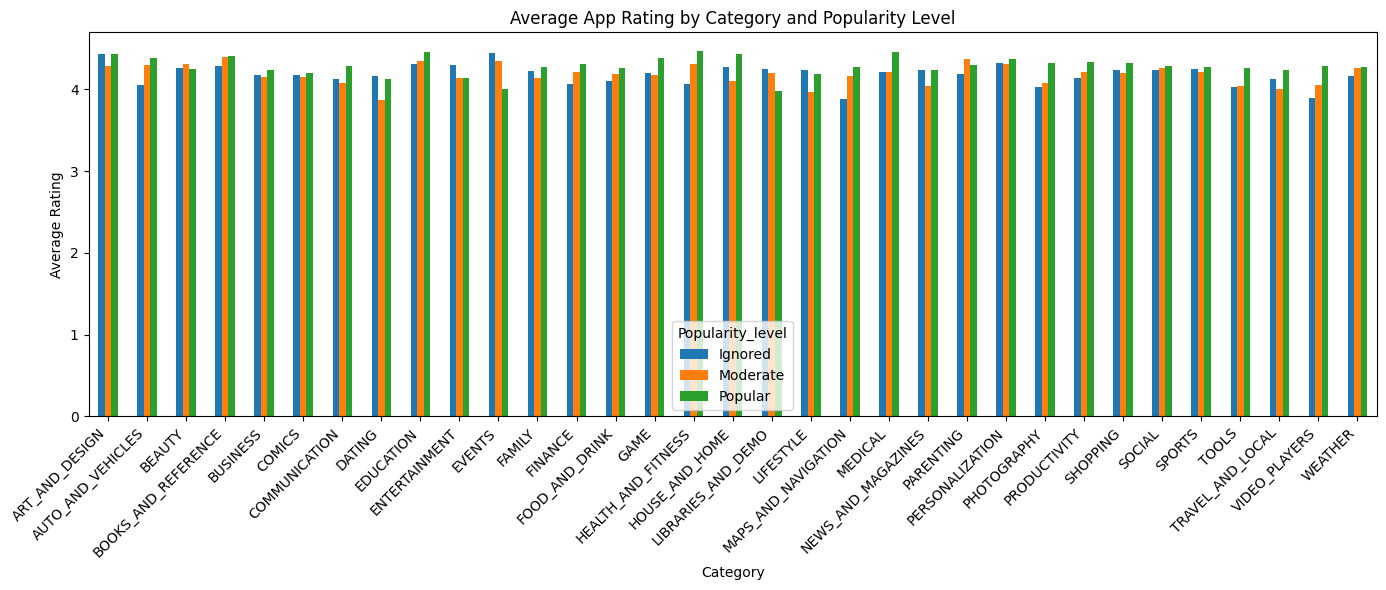

In [57]:
# 📈 Visualize average ratings by category and popularity level

pivot.plot(
    kind="bar",
    figsize=(14, 6),
    title="Average App Rating by Category and Popularity Level",
    ylabel="Average Rating"
)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 📌 Insight
Across most categories, **popular apps tend to have higher average ratings** than ignored or moderately popular apps.  
This suggests that while high ratings do not guarantee popularity, **sustained popularity is rarely achieved without strong user satisfaction**.


In [58]:
# ❓ Are lightweight popular apps rated better than heavy popular apps?

# Create size groups
df["Size_Group"] = np.where(df["Size_MB"] < 20, "Light", "Heavy")

# Cross-tabulation of Size, Popularity, and App Quality (percentage)
size_popularity_quality = (
    pd.crosstab(
        [df["Size_Group"], df["Popularity_level"]],
        df["App_Quality"],
        normalize="index"
    ) * 100
)

size_popularity_quality


App_Quality                       Bad    Average       Good
Size_Group Popularity_level                                
Heavy      Ignored           7.247796  18.511263  74.240940
           Moderate          1.743745  28.809704  69.446550
           Popular           0.195503  11.241447  88.563050
Light      Ignored           5.977230  17.805187  76.217584
           Moderate          3.014417  27.959808  69.025775
           Popular           0.324044  15.230071  84.445885

### 📌 Insight
For popular apps, both lightweight and heavy apps are overwhelmingly **good quality (≈85–89%)**.  
App size has **minimal influence on popularity or perceived quality** once an app is popular.  
This indicates that **quality matters far more than size** in driving successful, popular apps.


In [59]:
# ❓ Do apps supporting older Android versions achieve wider reach?

# Group apps by Android version support
df["Android_Group"] = np.where(
    df["Android_Ver_Min"] <= 5,
    "Older Android",
    "Newer Android"
)

# Compare average installs
df.groupby("Android_Group")["Installs"].mean()


Android_Group
Newer Android    3.001802e+06
Older Android    1.430178e+07
Name: Installs, dtype: float64

In [60]:
# Compare median installs (more robust)
df.groupby("Android_Group")["Installs"].median()


Android_Group
Newer Android     10000.0
Older Android    100000.0
Name: Installs, dtype: float64

In [61]:
# ❓ Do apps supporting older Android versions achieve wider reach?

# Create Android compatibility groups
df["Android_Group"] = np.where(
    df["Android_Ver_Min"] <= 5,
    "Older Android",
    "Newer Android"
)

# Compare average installs
df.groupby("Android_Group")["Installs"].mean()


Android_Group
Newer Android    3.001802e+06
Older Android    1.430178e+07
Name: Installs, dtype: float64

### 📌 Insight
Apps that support **older Android versions** have a significantly higher average number of installs.  
This suggests that broader Android compatibility increases potential reach, especially in regions where older devices are still common.

**Note:** Using median installs can further validate this result by reducing the influence of extremely popular apps.


🔹 Phase 3: Reviews Dataset Analysis

   Load the Reviews Dataset

In [62]:
import pandas as pd
import numpy as np

reviews_df = pd.read_csv("../data/review_data.csv")

# Basic checks
reviews_df.shape
reviews_df.info()
reviews_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


Initial Data Quality Check

In [63]:
# Missing values
reviews_df.isnull().sum()

# Duplicate rows
reviews_df.duplicated().sum()


np.int64(33616)

🧹 Data Cleaning — Reviews Dataset


In [64]:
# Remove rows with missing values
reviews_clean = reviews_df.dropna()

# Verify missing values
reviews_clean.isnull().sum()


App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

reviews_clean.info()


Remove Duplicate Reviews

In [65]:
# Remove duplicate rows
reviews_clean = reviews_clean.drop_duplicates()

# Check duplicates
reviews_clean.duplicated().sum()


np.int64(0)

In [66]:
# Reset index after cleaning
reviews_clean.reset_index(drop=True, inplace=True)

reviews_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29692 entries, 0 to 29691
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     29692 non-null  object 
 1   Translated_Review       29692 non-null  object 
 2   Sentiment               29692 non-null  object 
 3   Sentiment_Polarity      29692 non-null  float64
 4   Sentiment_Subjectivity  29692 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.1+ MB


The index was reset after cleaning to maintain a clean and sequential dataframe structure.


Text Normalization

In [67]:
# Convert reviews to lowercase
reviews_clean["Translated_Review"] = (
    reviews_clean["Translated_Review"].str.lower()
)


6️⃣ Sentiment Statistics Overview

In [68]:
reviews_clean[["Sentiment_Polarity", "Sentiment_Subjectivity"]].describe()


,Sentiment_Polarity,Sentiment_Subjectivity
count,29692.000000,29692.000000
mean,0.188868,0.490930
std,0.355694,0.265976
min,-1.000000,0.000000
25%,0.000000,0.350000
50%,0.157143,0.514286
75%,0.422917,0.652703
max,1.000000,1.000000


- **Sentiment Polarity** ranges from -1 (negative) to +1 (positive), with a positive mean indicating overall favorable sentiment.
- **Sentiment Subjectivity** values suggest that most reviews contain a mix of personal opinion and factual information.


❓ What is the distribution of sentiment in user reviews?

In [69]:
# Sentiment distribution (counts)
reviews_clean["Sentiment"].value_counts()

# Sentiment distribution (percentage)
reviews_clean["Sentiment"].value_counts(normalize=True) * 100


Sentiment
Positive    64.040819
Negative    21.288563
Neutral     14.670618
Name: proportion, dtype: float64

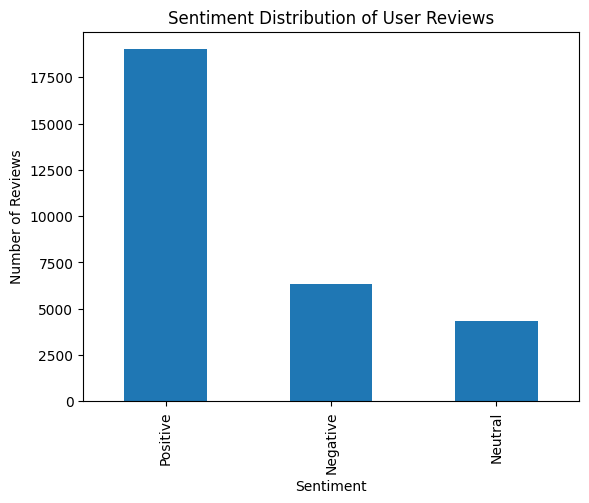

In [70]:
# Visualization
reviews_clean["Sentiment"].value_counts().plot(
    kind="bar",
    title="Sentiment Distribution of User Reviews"
)
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


Most user reviews express **positive sentiment**, followed by neutral reviews.
Negative reviews make up a smaller proportion, indicating generally favorable user perception of apps on the Play Store.


❓ How are sentiment polarity scores distributed?

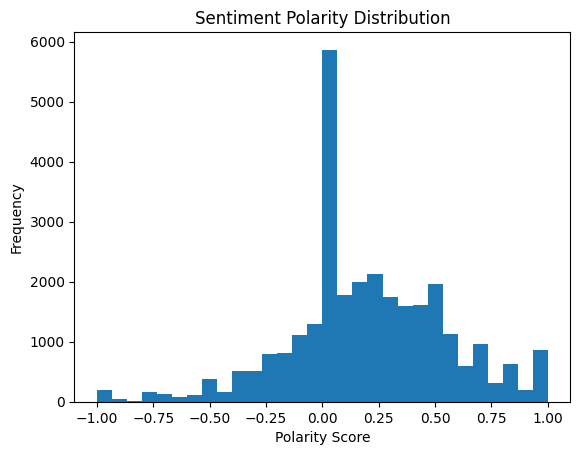

In [71]:
# Statistical Summary

reviews_clean["Sentiment_Polarity"].describe()

# Visualization

plt.hist(reviews_clean["Sentiment_Polarity"], bins=30)
plt.title("Sentiment Polarity Distribution")
plt.xlabel("Polarity Score")
plt.ylabel("Frequency")
plt.show()



Sentiment polarity values range from -1 (strongly negative) to +1 (strongly positive.
The distribution is skewed toward positive values, confirming that most reviews express positive opinions.
Extreme negative and positive sentiments exist but are relatively rare.


# ❓ Question 3: How subjective are user reviews?

<Axes: >

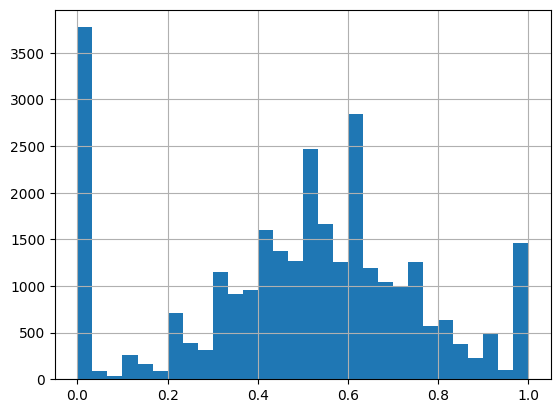

In [72]:

reviews_clean["Sentiment_Subjectivity"].describe()

reviews_clean["Sentiment_Subjectivity"].hist(bins=30)

# ❓ Question 4: How many reviews does each app receive? (Categorical frequency)

In [73]:


reviews_per_app = reviews_clean["App"].value_counts()
reviews_per_app.describe()

count    865.000000
mean      34.326012
std       19.884565
min        1.000000
25%       27.000000
50%       35.000000
75%       39.000000
max      130.000000
Name: count, dtype: float64

The number of reviews per app ranges from 1 to 130, with an average of about 34 reviews per app. The distribution shows moderate variability, indicating that while most apps receive a similar number of reviews, a small subset attracts relatively higher engagement. Unlike typical app-store data, extreme review concentration is not observed in this dataset.

# ❓ Question 5: Are there extreme sentiment values (outliers)?

<Axes: >

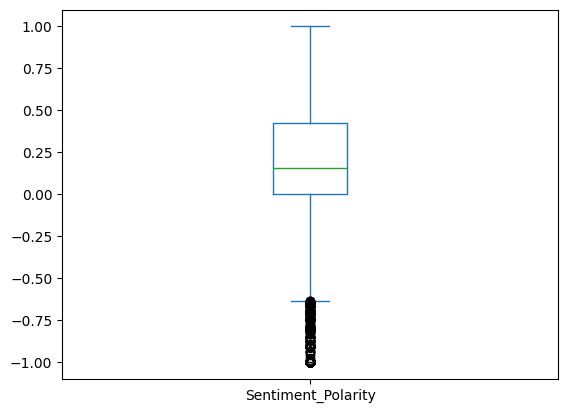

In [74]:


reviews_clean["Sentiment_Polarity"].describe()
reviews_clean["Sentiment_Polarity"].plot(kind="box")

User reviews are generally positive, but strong emotional outliers exist and should be retained for analysis.

🔗 Merging Apps & Reviews Data
❓ How many apps do not have associated user reviews?

In [75]:
merged_df = df.merge(
    reviews_clean,
    on="App",
    how="left"
)


In [76]:
# Missing Sentiment After Merge

merged_df["Sentiment_Polarity"].isna().mean() * 100


np.float64(18.671013442807695)

Approximately **18.7% of apps have no associated user reviews**, resulting in missing sentiment polarity values after merging.

These apps were retained in the dataset due to the **left join strategy**, ensuring no loss of app-level information.  
However, apps without reviews were **excluded from sentiment-based analyses**, as sentiment metrics are unavailable for them.


📊 Impact of Reviews on App Performance
❓ Are apps with reviews different from apps without reviews?

In [77]:
# Create a dataframe only for sentiment-based analysis
sentiment_df = merged_df.dropna(subset=["Sentiment_Polarity"])

# Flag apps that have at least one review
merged_df["Has_Review"] = merged_df["Sentiment_Polarity"].notna()


In [78]:
# 📈 Compare Installs by Review Presence
merged_df.groupby("Has_Review")["Installs"].mean()


Has_Review
False    1.035278e+07
True     5.901111e+07
Name: Installs, dtype: float64

In [79]:
# ⭐ Compare Ratings by Review Presence
merged_df.groupby("Has_Review")["Rating"].mean()


Has_Review
False    4.191862
True     4.324615
Name: Rating, dtype: float64

Apps that have user reviews show **significantly higher average installs** and **slightly higher average ratings** compared to apps without reviews.

This suggests that user reviews are strongly associated with an app’s **visibility, popularity, and perceived credibility**. Apps without reviews tend to have lower reach and marginally lower user trust.


⭐ Sentiment Polarity vs App Rating
❓ Does higher sentiment polarity relate to higher ratings?

In [80]:
# Correlation Analysis
merged_df[["Sentiment_Polarity", "Rating"]].corr()


,Sentiment_Polarity,Rating
Sentiment_Polarity,1.000000,0.075208
Rating,0.075208,1.000000


The correlation between **sentiment polarity** and **app rating** is very weak, indicating no strong linear relationship.

This suggests that:
- Apps with more positive review sentiment do **not necessarily** have higher ratings.
- Ratings reflect overall user evaluation, while sentiment polarity captures emotional tone of individual reviews.

Therefore, sentiment polarity should be used as a **complementary signal**, not a substitute for ratings.


📝 Review Length vs Sentiment Subjectivity
❓ Are longer reviews more subjective?

In [81]:
merged_df["Review_Length"] = (
    merged_df["Translated_Review"]
    .astype(str)
    .apply(len)
)


In [82]:
merged_df[["Review_Length", "Sentiment_Subjectivity"]].corr()


,Review_Length,Sentiment_Subjectivity
Review_Length,1.000000,0.023811
Sentiment_Subjectivity,0.023811,1.000000


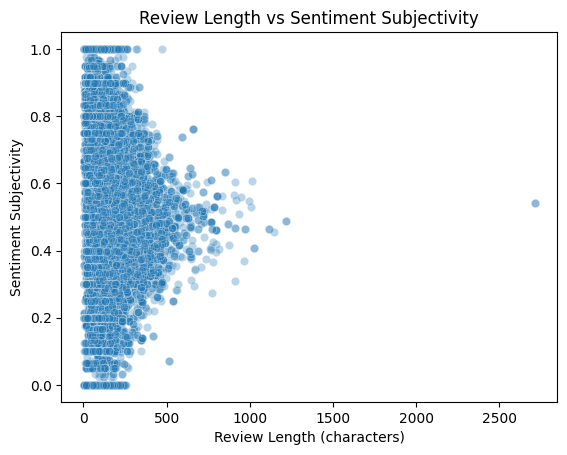

In [83]:
# Visualization
sns.scatterplot(
    data=merged_df,
    x="Review_Length",
    y="Sentiment_Subjectivity",
    alpha=0.3
)
plt.title("Review Length vs Sentiment Subjectivity")
plt.xlabel("Review Length (characters)")
plt.ylabel("Sentiment Subjectivity")
plt.show()


The correlation between **review length** and **sentiment subjectivity** is extremely weak (≈ 0.02).

This indicates that:
- Longer reviews are not necessarily more opinion-based.
- Strong personal opinions can be expressed in both short and long reviews.
- Review length does not meaningfully influence how subjective a review is.


⭐ Sentiment vs Rating Across Popularity Levels
❓ Does sentiment matter more for popular apps than unpopular ones?

In [84]:
merged_df.groupby(
    "Popularity_level",
    observed=True
)[["Sentiment_Polarity", "Rating"]].corr()




Sentiment_Polarity    Rating
Popularity_level                                                 
Ignored          Sentiment_Polarity            1.000000  0.158526
                 Rating                        0.158526  1.000000
Moderate         Sentiment_Polarity            1.000000  0.165432
                 Rating                        0.165432  1.000000
Popular          Sentiment_Polarity            1.000000  0.050303
                 Rating                        0.050303  1.000000

The relationship between **sentiment polarity** and **app rating** is weak across all popularity levels.

- The correlation is slightly higher for **Ignored** and **Moderate** apps.
- For **Popular** apps, the relationship becomes very weak.

This suggests that ratings of highly popular apps are less influenced by individual review sentiment.
